Excel Dosyasını Okuma

In [2]:

import pandas as pd

file_path = "intents.xlsx"  
df = pd.read_excel(file_path)

Her Satırı Document Nesnesine Dönüştürme

In [3]:
from langchain_core.documents import Document

docs = []
for idx, row in df.iterrows():
    content = row["kullanici_soru"]
    metadata = {"intent": row["intent_basligi"], "row_id": idx}
    doc = Document(page_content=content, metadata=metadata)
    docs.append(doc)

print("Toplam belge:", len(docs))

Toplam belge: 1000


Veriyi Test ve Eğitim Verisi Olarak Bölme

In [4]:
from sklearn.model_selection import train_test_split

# Rastgele eğitim ve test verisi olarak bölme
train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=42)

# Eğitim ve test veri setlerinin uzunluğunu kontrol etme
print("Eğitim verisi uzunluğu:", len(train_docs))
print("Test verisi uzunluğu:", len(test_docs))

Eğitim verisi uzunluğu: 800
Test verisi uzunluğu: 200


In [5]:
train_docs[25]

Document(metadata={'intent': 'restoran_kafe', 'row_id': 2}, page_content='Deniz ürünleriyle ünlü restoranlar nerede bulunur?')

OpenAI Generative AI Embeddings'i kullanarak Embedding Oluşturma İşlemi

In [6]:
from langchain_community.vectorstores import Chroma
from dotenv import load_dotenv
from langchain.embeddings import OpenAIEmbeddings

In [7]:
load_dotenv()

True

In [8]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

C:\Users\CASPER\AppData\Local\Temp\ipykernel_16652\2421187937.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model="text-embedding-3-large")


ChromaDB Üzerine Kayıt İşlemi

In [9]:
vectorstore = Chroma.from_documents(documents=train_docs, embedding=embeddings,persist_directory="./chroma_db")

In [10]:
retriever = vectorstore.as_retriever(
    search_type="similarity", search_kwargs={"k":4}
)

In [11]:
retieved_docs = retriever.invoke("merhaba")

In [12]:
len(retieved_docs)

4

In [13]:
print(retieved_docs[3].page_content)

Merhaba  


OpenAI API Yapısını Kullanarak LLM Tetikleme İşlemleri

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.3,
    max_tokens=500
)

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

In [ ]:
system_prompt = (
    "Sen, turistlere rehberlik eden bir chatbot'sun."
    "Aşağıda verilen bağlamlara göre en uygun cevabı ver."
    "Yanıtlarını mümkün olduğunca kısa ve net tut, üç cümleyi geçmemeye çalış. "
    "Eğer cevabı bilmiyorsan 'Bilmiyorum' diye belirt."
    "\n\n{context}"
)

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system",system_prompt),
        ("human","{input}")
    ]
)

Soru-Cevap Zinciri Oluşturma(LLM+PROMPT)

In [18]:
question_answer_chain = create_stuff_documents_chain(llm,prompt)

RAG Zinciri Oluşturma(RAG+LLM Entegrasyonun Gerçekleşmesi)

In [19]:
rag_chain = create_retrieval_chain(retriever,question_answer_chain)

Kullanıcı Sorgusunu Çalıştırarak Cevap Üretme İşlemi

In [20]:
response = rag_chain.invoke({"input":"Paris'te şehrin merkezine yakın otel önerir misin?"})

In [21]:
print(response)

{'input': "Paris'te şehrin merkezine yakın otel önerir misin?", 'context': [Document(metadata={'intent': 'konaklama', 'row_id': 397}, page_content='Merkezi konumda otel önerisi?'), Document(metadata={'intent': 'konaklama', 'row_id': 397}, page_content='Merkezi konumda otel önerisi?'), Document(metadata={'intent': 'konaklama', 'row_id': 397}, page_content='Merkezi konumda otel önerisi?'), Document(metadata={'intent': 'konaklama', 'row_id': 397}, page_content='Merkezi konumda otel önerisi?')], 'answer': "Hotel Le Meurice veya Hôtel de Crillon, Paris'in merkezine yakın lüks seçeneklerdir. Daha uygun fiyatlı bir seçenek için Hôtel du Louvre'u düşünebilirsiniz."}


PERFORMANS METRİKLERİ

In [ ]:
import time
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score

def extract_predicted_intent(chatbot_response):
    intents = [doc.metadata['intent'] for doc in chatbot_response['context']]
    most_common_intent, _ = Counter(intents).most_common(1)[0]
    return most_common_intent

y_true = []
y_pred = []

for idx, doc in enumerate(test_docs):
    question = doc.page_content
    true_intent = doc.metadata['intent']
    
    chatbot_response = rag_chain.invoke({"input": question})
    predicted_intent = extract_predicted_intent(chatbot_response)
    
    y_true.append(true_intent)
    y_pred.append(predicted_intent)
    
    # Her çağrıdan sonra 5 saniye bekle
    time.sleep(5)

    if (idx + 1) % 10 == 0:
        print(f"{idx + 1} soru işlendi")

print("Doğruluk (Accuracy):", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

10 soru işlendi
20 soru işlendi
30 soru işlendi
40 soru işlendi
50 soru işlendi
60 soru işlendi
70 soru işlendi
80 soru işlendi
90 soru işlendi
100 soru işlendi
110 soru işlendi
120 soru işlendi
130 soru işlendi
140 soru işlendi
150 soru işlendi
160 soru işlendi
170 soru işlendi
180 soru işlendi
190 soru işlendi
200 soru işlendi
Doğruluk (Accuracy): 0.96
                  precision    recall  f1-score   support

     acil_yardim       0.93      1.00      0.96        13
   doviz_bilgisi       1.00      0.96      0.98        25
     etkinlikler       0.82      0.93      0.88        15
gezilecek_yerler       0.96      0.81      0.88        27
     hava_durumu       1.00      1.00      1.00        22
       konaklama       1.00      0.95      0.98        21
   restoran_kafe       1.00      1.00      1.00        20
      selamlasma       1.00      1.00      1.00        11
          ulasim       0.81      1.00      0.90        13
       vedalasma       1.00      1.00      1.00        10
vize

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
report = classification_report(y_true, y_pred, zero_division=0)  

print(report)  


print("Doğruluk (Accuracy):", accuracy_score(y_true, y_pred))
print("Kesinlik (Precision):", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Duyarlılık (Recall):", recall_score(y_true, y_pred, average='weighted', zero_division=0))
print("F1 Skoru (F1-Score):", f1_score(y_true, y_pred, average='weighted', zero_division=0))


                  precision    recall  f1-score   support

     acil_yardim       0.93      1.00      0.96        13
   doviz_bilgisi       1.00      0.96      0.98        25
     etkinlikler       0.82      0.93      0.88        15
gezilecek_yerler       0.96      0.81      0.88        27
     hava_durumu       1.00      1.00      1.00        22
       konaklama       1.00      0.95      0.98        21
   restoran_kafe       1.00      1.00      1.00        20
      selamlasma       1.00      1.00      1.00        11
          ulasim       0.81      1.00      0.90        13
       vedalasma       1.00      1.00      1.00        10
vize_ve_belgeler       1.00      1.00      1.00        23

        accuracy                           0.96       200
       macro avg       0.96      0.97      0.96       200
    weighted avg       0.96      0.96      0.96       200

Doğruluk (Accuracy): 0.96
Kesinlik (Precision): 0.9640647835221046
Duyarlılık (Recall): 0.96
F1 Skoru (F1-Score): 0.96018145864

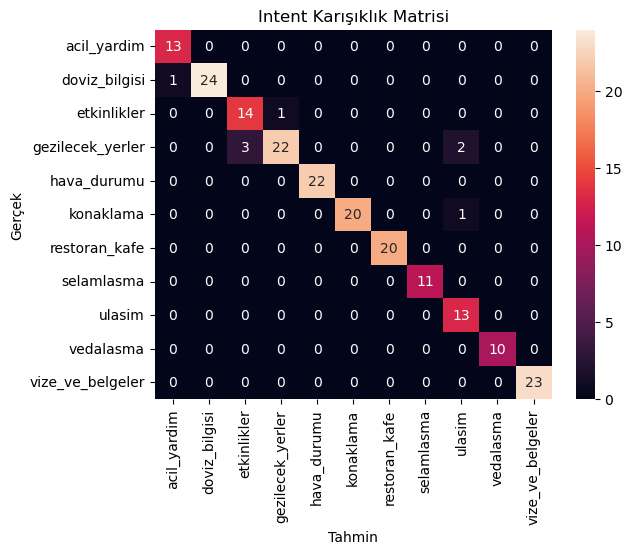

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)))
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Intent Karışıklık Matrisi')
plt.show()